In [1]:
from ple.games.flappybird import FlappyBird
from ple import PLE
import random
import numpy as np
import pickle
from classes import StackedImages, ImageProcessor
from IPython.display import clear_output


from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.models import load_model


from collections import deque

import timeit

from skimage import io
import matplotlib.pyplot as plt



#data_input = '/users/momori/data/stacked_images.pkl'

couldn't import doomish
Couldn't import doom


Using TensorFlow backend.


## Image Processing with CNN (Convolutional Neural Network)

input shape is (4,288, 512)

In [2]:
def update_reward(value):
    #return value
    if value==0.0:
        return 0.1
    elif value==5.0:
        print 'score!!'
        return 5.0
    elif value==-5:
        return -5.0
    else:
        return value

def test_game(agent, debug=False, show_screen=False):
    #init the game flappybird
    game = FlappyBird()

    #set up the screen
    p = PLE(game, fps=30, display_screen=show_screen)

    p.init()

    observations = deque()

    max_frames = 100 ##first frame is null
    num_frame_stacks = 4
    num_to_observe = 12 #observations before we train the network
    #batch_count = 12 #train the model by selecting some subsample of the stored replays
                    #contains lists of replay envs. each element is in the format
                    #[state, action, reward, new_state, terminal(boolean)]
    epsilon = 0.8 #when to choose the known best action vs random action
    gamma = 0.8 #importance of future rewards compared to current reward
    
    total_reward = 0

    replay_data = deque() 

    test_stacked_images = []
    
    game_over = False
    for i in range(0, max_frames):
        observation = p.getScreenRGB()
        if np.max(observation) != 0:
            observations.append(observation)


        ##after num_frame_stacks frames pass, we start predicting actions
        if len(observations) == num_frame_stacks:
            image_processors = [ImageProcessor(observations[j])
                               for j in range(num_frame_stacks)]
            stacked_images = StackedImages(image_processors, num_frame_stacks)
            test_stacked_images.append(stacked_images)
            action, output = agent.predict(stacked_images.get_stacked_images())
            
            if debug:
                print(i, action, output)
           
            reward = update_reward(p.act(action))
            total_reward += reward
            #print action, output

            #get new state and create the replay data
            observation = p.getScreenRGB()
#             replay_data.append([stacked_images, action, reward, 
#                                 ImageProcessor(observation),p.game_over()])

            #remove the oldest state so new state can be added in next iteration
            observations.popleft()

        else: ##first few frames, do nothing
            p.act(None)

        #if game over, reset the game and the observations queue
        if p.game_over():
            p.reset_game()
            observations = deque()
            break
    if debug:
        return (total_reward, test_stacked_images)
    return total_reward

In [11]:

class PolicyAgent():
    '''agent to learn and provide optimal actions during the game run.
    the output is the expected reward for taking that action in that state
    output:
        higher index 0 -> flap
        higher index 1 -> do nothing
        '''
    def __init__(self):
        ##cnn 
        model = Sequential()
        model.add(Conv2D(64, (8,8), activation='sigmoid', input_shape=(input_num_rows, input_num_cols, 4)))
        model.add(MaxPooling2D(pool_size=(10,10)))
        model.add(Flatten())
        model.add(Dense(10, activation='sigmoid'))
        #model.add(Dense(2, activation='softmax'))
        model.add(Dense(2, activation='sigmoid'))
        #model.compile(loss='categorical_crossentropy', optimizer='sgd')
        model.compile(loss='mse', optimizer='sgd')

        self._model = model
    
    
    def fit(self, x_data, y_data, batch_size=32, epochs=1):
        x_data = x_data.reshape(1, x_data.shape[1], x_data.shape[2], x_data.shape[0])
        y_data = np.array(y_data).reshape(1,2)
        self._model.fit(x_data, y_data, batch_size, epochs, verbose=0)
        
    def predict(self, x_data):
        x_data = x_data.reshape(1, x_data.shape[1], x_data.shape[2], x_data.shape[0])
        output = self._model.predict(x_data)
        #print 'predict', output
        index = np.random.choice(np.flatnonzero(output==np.max(output)))
#         if output[0][0] > output[0][1]:
#             action = 119
#         else:
#             action = None
        if index==0:
            action = 119
        else:
            action = None
        return action, output
    
    def save_weights(self, file_name):
        self._model.save_weights(file_name, overwrite=True)
        
    
    def train_on_batch(self, x_data, y_data):
        #x_data = x_data.reshape(1, x_data.shape[1], x_data.shape[2], x_data.shape[0])
        self._model.train_on_batch(x_data, y_data)
        
    def summary(self):
        return self._model.summary()
    
    def load_weights(self, file_name):
        self._model.load_weights(file_name)
        self._model.compile(loss='mse', optimizer='sgd')
        

In [4]:
###############
'''

OLD


'''
def train_policy(agent, replay_data, num_frame_stacks=4, batch_count=0):
    '''use the replay data to train the network
    agent: PolicyAgent object
    replay_data: queue of lists
                 [0]: StackedImage object (current state)
                 [1]: Action
                 [2]: Reward
                 [3]: ImageProcessor object (next state)
                 [4]: is game terminal (boolean)
    num_frame_stack: number of frames to stack as one data sample
    batch_count: non-zero value indicates to use experience replay. 
                 # of frames to use from this replay_data to train the network
    '''
    #if batch_count is not 0, we use random sampling of the replay data
    if batch_count != 0:
        replay_data = random.sample(replay_data, batch_count)

    #inputs/targets for training the neural network
    #inputs = []
    #targets = []

    for i in range(0,len(replay_data),num_frame_stacks):
        #print replay_data
        #print replay_data[i][0].plot()
        curr_state = replay_data[i][0].get_stacked_images()

        #modified later to keep track of next stacked frames
        next_state = np.split(curr_state, num_frame_stacks, axis=0)

        action = replay_data[i][1]
        if action == 119:  #change to proper index of the action output
            action = 0
        else:
            action = 1
        reward = replay_data[i][2]
        next_frame = replay_data[i][3].gray_image\
            .reshape(1, input_num_rows, input_num_cols) #reshape to  stack properly onto the current state

        #append latest state and pop the earliest
        next_state.append(next_frame)
        next_state.pop(0)

        is_terminal = replay_data[i][4]

        #get the highest reward possible in the next state
        _, output = agent.predict(np.concatenate(next_state, axis=0))
        next_reward = np.max(output)
        
        print i, is_terminal,
        replay_data[i][0].plot()
        print '----------------'

        
        #print reward, output, is_terminal
        
        
        
        #if terminal, no more rewards
        if is_terminal:
            total_reward = update_reward(-5)
            print 'terminal reward:', total_reward
            replay_data[i][0].plot()
        else:
            total_reward = reward + gamma * next_reward

        #inputs.append(curr_state)
        #targets.append(output[0])
        output[0][action] = total_reward

        #debug***************************************
        #if is_terminal:
            #print replay_data[i][0].plot()
            #print 'fitting with target', curr_state.shape, output[0]
        
        agent.fit(curr_state, output[0])

        
    return agent



In [5]:
def train_policy(agent, replay_data, num_frame_stacks=4, batch_count=0):
    '''use the replay data to train the network
    agent: PolicyAgent object
    replay_data: queue of lists
                 [0]: StackedImage object (current state)
                 [1]: Action
                 [2]: Reward
                 [3]: ImageProcessor object (next state)
                 [4]: is game terminal (boolean)
    num_frame_stack: number of frames to stack as one data sample
    batch_count: non-zero value indicates to use experience replay. 
                 # of frames to use from this replay_data to train the network
    '''
    #if batch_count is not 0, we use random sampling of the replay data
    if batch_count != 0:
        replay_data = random.sample(replay_data, batch_count)

    #inputs/targets for training the neural network
    #inputs = []
    #targets = []

    for i in range(0,len(replay_data)):
        #print replay_data
        #print replay_data[i][0].plot()
        curr_state = replay_data[i][0].get_stacked_images()

        #modified later to keep track of next stacked frames
        next_state = np.split(curr_state, num_frame_stacks, axis=0)

        action = replay_data[i][1]
        if action == 119:  #change to proper index of the action output
            action = 0
        else:
            action = 1
        reward = replay_data[i][2]
        next_frame = replay_data[i][3].gray_image\
            .reshape(1, input_num_rows, input_num_cols) #reshape to  stack properly onto the current state

        #append latest state and pop the earliest
        next_state.append(next_frame)
        next_state.pop(0)

        #print 'flag', replay_data[i][4]
        
        is_terminal = replay_data[i][4]

        #get the highest reward possible in the next state
        _, output = agent.predict(np.concatenate(next_state, axis=0))
        next_reward = np.max(output)
        
        #print i, is_terminal
        #replay_data[i][0].plot()
        #print '----------------'

        
        #print reward, output, is_terminal
        
        
        
        #if terminal, no more rewards
        if is_terminal:
            total_reward = update_reward(-5)
            #print 'terminal reward:', total_reward
            #replay_data[i][0].plot()
        else:
            total_reward = reward + gamma * next_reward

        #inputs.append(curr_state)
        #targets.append(output[0])
        output[0][action] = total_reward

        #debug***************************************
        if is_terminal:
            pass
            #print 'terminal'
            #replay_data[i][0].plot()
            #print 'fitting with target', curr_state.shape, output[0]
        
        agent.fit(curr_state, output[0])

        
    return agent



In [9]:
# image = p.getScreenRGB()
# ImageProcessor(image).shape()[0]

('original image shape:', (288, 512, 3))
('gray image eshape:', (96, 135))


96

('original image shape:', (288, 512, 3))
('gray image eshape:', (96, 135))
('original image shape:', (288, 512, 3))
('gray image eshape:', (96, 135))
[-5, 0]


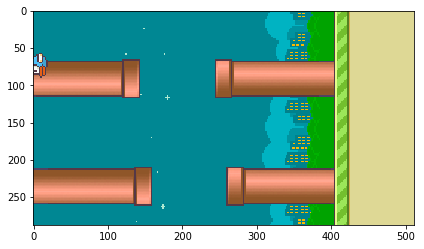

[-5, 0]


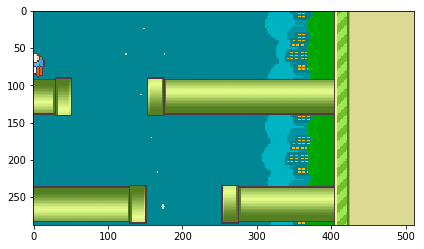

[0, -5]


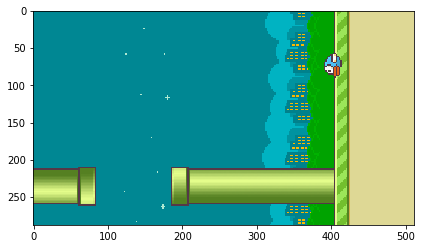

[-5, 0]


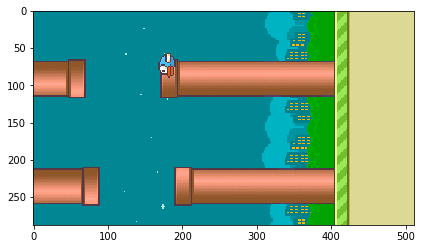

[0, -5]


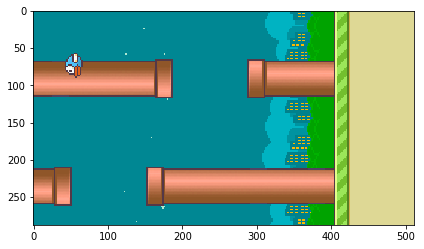

[0, -5]


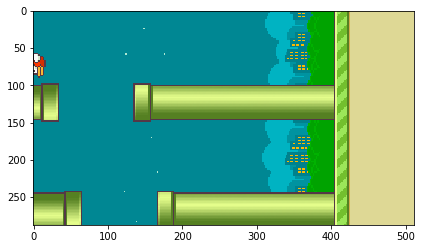

[-5, 0]


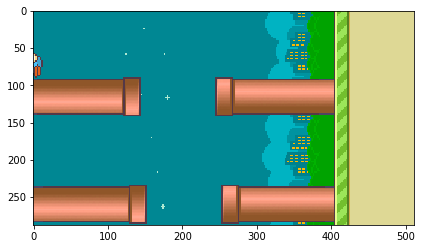

[-5, 0]


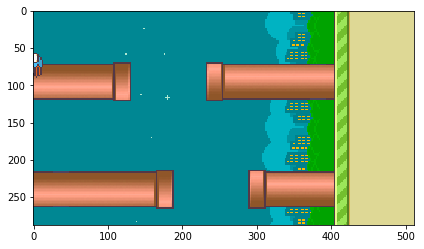

[0, -5]


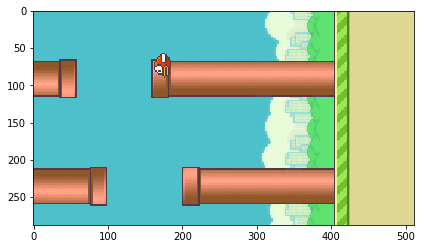

[-5, 0]


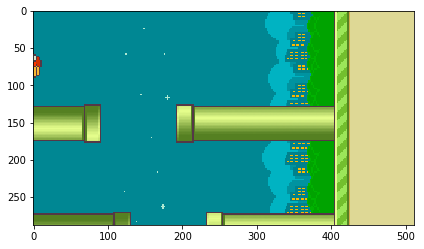

[-5, 0]


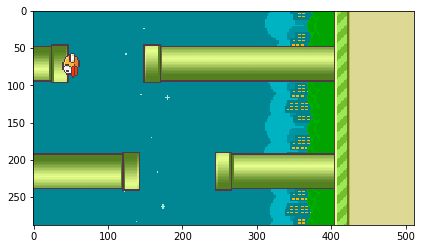

[-5, 0]


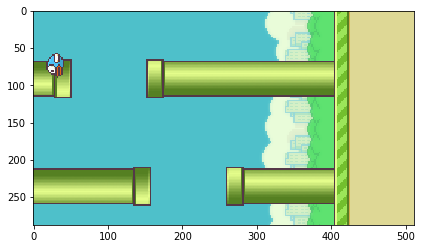

[-5, 0]


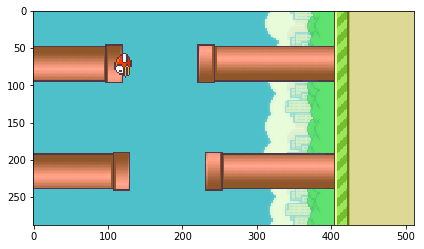

[0, -5]


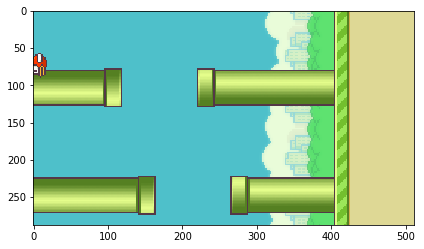

[0, -5]


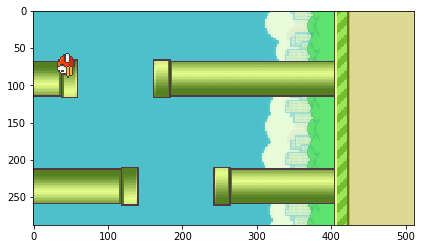

[-5, 0]


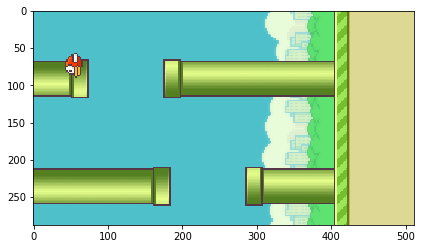

[-5, 0]


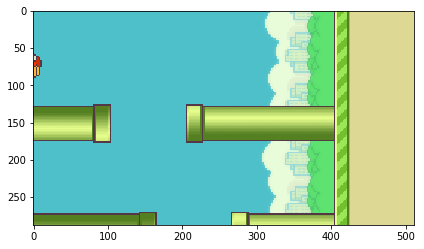

finished


In [21]:
import os
##disable graphics for cloud computing
#os.putenv('SDL_VIDEODRIVER', 'fbcon')
#os.environ["SDL_VIDEODRIVER"] = "dummy"

#%%time
output_file = 'logs/log'
#clear log file
open(output_file, 'w').close()

#init the game flappybird
game = FlappyBird()

#set up the screen
p = PLE(game, fps=30, display_screen=True)

p.init()

agent = PolicyAgent()


#pre_training_weights = agent._model.get_weights()

'''values to change in AWS env'''
max_frames = 1000#640000 ##first frame is null
num_frame_stacks = 4
num_to_observe = int(max_frames * 0.1)#3200 #observations before we train the network
batch_count = int(num_to_observe * 0.8)  #train the model by selecting some subsample of the stored replays
                #contains lists of replay envs. each element is in the format
                #[state, action, reward, new_state, terminal(boolean)]
save_every = int(max_frames * 0.2) ##save the weights of the model every x frames
frames_per_action = 4 #only act on every x frames
       
    
#set up the right dimensions
image = p.getScreenRGB()
input_num_rows = ImageProcessor(image).shape()[0]
input_num_cols = ImageProcessor(image).shape()[1]
epsilon = 0.2 #choose best action x% of the time
gamma = 0.9 #importance of future rewards compared to current reward
train_after_batch = True
count_game_over = 0
train_iteration_scores = []

observations = deque()
replay_data = [] 
print_flag = False

game_over = False

#start time
start_time = timeit.default_timer()

#get initial screen state
#observations.append(p.getScreenRGB())

last_action = None

for i in range(0, max_frames):
    #print out how long each x frames took
    if i % (max_frames/10) == 0:
        elapsed = timeit.default_timer() - start_time
        with open(output_file, 'a') as log_handle:
            log_handle.write('done with ' + str(i) + ' frames with ' + str(elapsed) + ' seconds\n')
        
        #reset timer
        start_time = timeit.default_timer()
        
    #save model weights every x iterations
    if i % save_every == 0 and i != 0:
        f_name = 'model_weights_'+str(i)
        agent.save_weights(f_name)
        
    #first num_frame_stacks frames, 
    #just do random action until we have enough data to stack
    if len(observations) < num_frame_stacks:
        action = np.random.choice([119, None])
        p.act(action)
        obs = p.getScreenRGB()
        observations.append(obs)
        continue
        

    #take an action every frames_per_action frames.
    if i % frames_per_action == 0 and i != 0:
        image_processors = [ImageProcessor(observations[index])
                    for index in range(num_frame_stacks)]
        stacked_images = StackedImages(image_processors, num_frame_stacks)
        if random.random() < epsilon:
            if random.random() < epsilon:
                action, output = agent.predict(stacked_images.get_stacked_images())
            else:
                action = np.random.choice([119, None])
        else:
            action = np.random.choice([119, None])
        last_action = action
        
        reward = update_reward(p.act(action))
        new_state = p.getScreenRGB()
        is_terminal = p.game_over()
        
         
        replay_data.append([stacked_images, last_action, reward,
                          ImageProcessor(new_state), is_terminal]  )
     
        observations.append(new_state)
        observations.popleft()
    
    #otherwise, do nothing:
    else:
        p.act(None)

    #once ready, train the network
    if len(replay_data) % num_to_observe == 0 and len(replay_data) > 0:
        agent = train_policy(agent, replay_data, num_frame_stacks, batch_count)
        
        #empty out the replay_data
        replay_data = deque()
        
    #if game_over, then we restart the environment
    if p.game_over():
        #get the latest saved state and update the agent accordingly
        #train on game_over
        if last_action == 119:
            target = [-5, 0]
        elif last_action == None:
            target = [0, -5]
        agent.fit(stacked_images.get_stacked_images(), target)
        

        if print_flag:
            print target
            io.imshow(p.getScreenRGB())
            plt.show()
        
        count_game_over += 1
        p.reset_game()
        observations = deque()
        #print 'game reset', i
        
print('finished')

In [ ]:
model_name = str(train_after_batch)+'_model'
agent._model.save('models/'+model_name)

In [19]:
tot_reward, tsi = test_game(agent, debug=True)


(4, 119, array([[ 0.24677864,  0.11862758]], dtype=float32))
(5, 119, array([[ 0.24679938,  0.11859956]], dtype=float32))
(6, 119, array([[ 0.24675149,  0.11861915]], dtype=float32))
(7, 119, array([[ 0.24676429,  0.11860563]], dtype=float32))
(8, 119, array([[ 0.24680829,  0.11857113]], dtype=float32))
(9, 119, array([[ 0.24674408,  0.11860442]], dtype=float32))
(10, 119, array([[ 0.24665713,  0.1186584 ]], dtype=float32))
(11, 119, array([[ 0.2466574 ,  0.11862778]], dtype=float32))
(12, 119, array([[ 0.24673973,  0.11853063]], dtype=float32))
(13, 119, array([[ 0.24671505,  0.11850691]], dtype=float32))
(14, 119, array([[ 0.24670222,  0.11849511]], dtype=float32))
(15, 119, array([[ 0.24664205,  0.11851548]], dtype=float32))
(16, 119, array([[ 0.24662134,  0.11846194]], dtype=float32))
(17, 119, array([[ 0.24647954,  0.11852928]], dtype=float32))
(18, 119, array([[ 0.24645418,  0.11850409]], dtype=float32))
(19, 119, array([[ 0.24653785,  0.11844634]], dtype=float32))
(20, 119, arra

In [15]:
# io.imshow(im._images[0]._orig_image)
# plt.show()

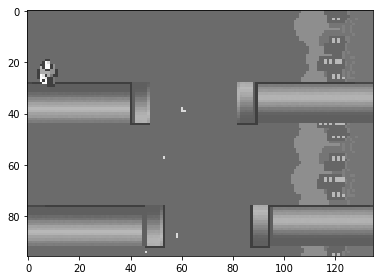

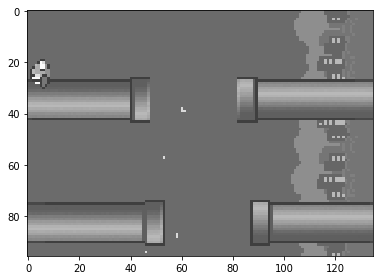

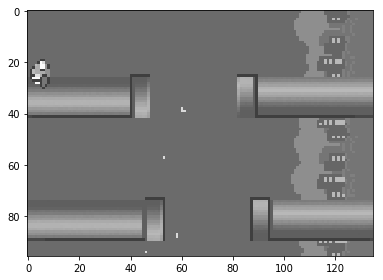

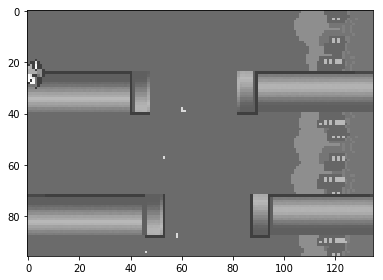

-------------


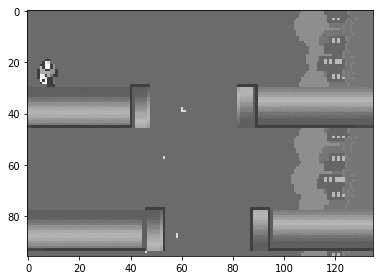

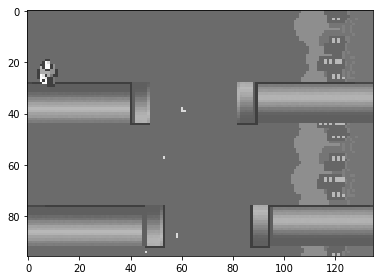

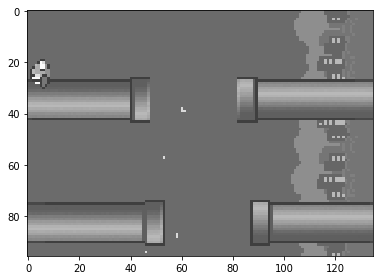

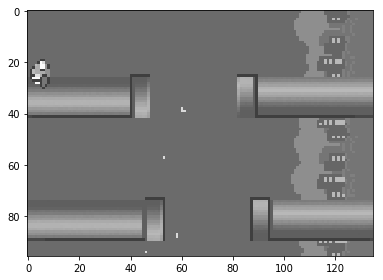

-------------


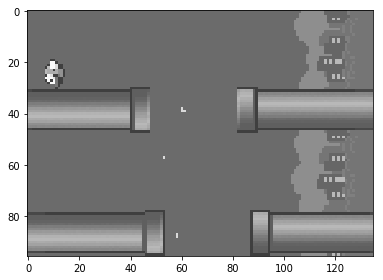

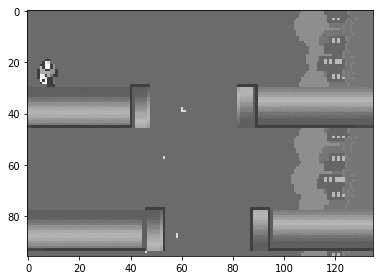

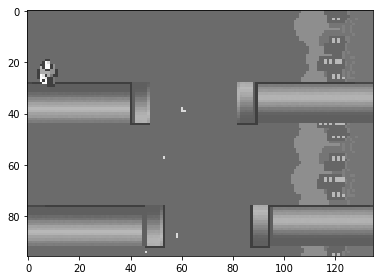

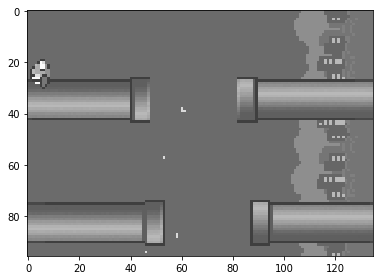

-------------


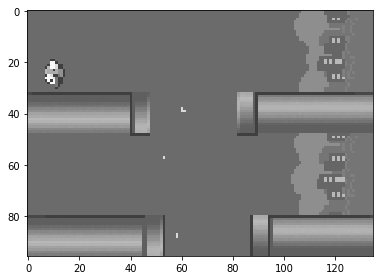

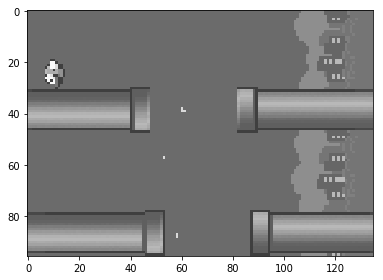

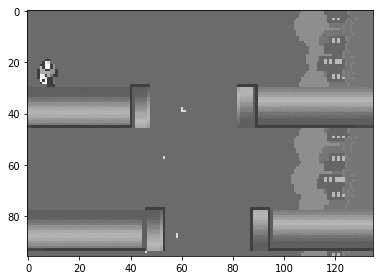

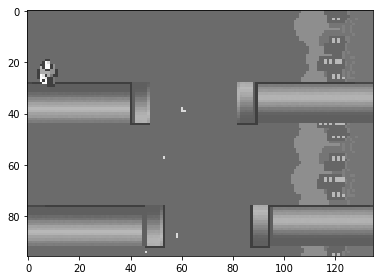

-------------


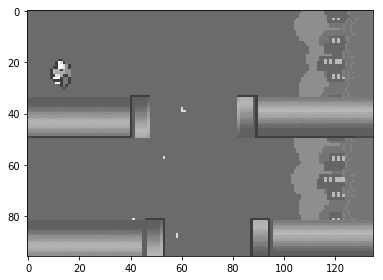

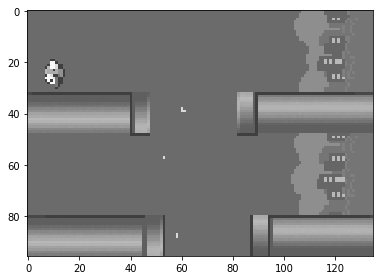

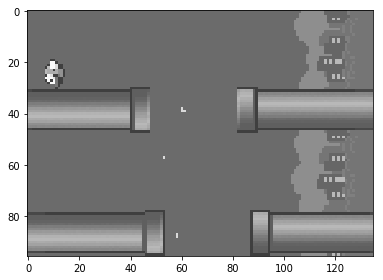

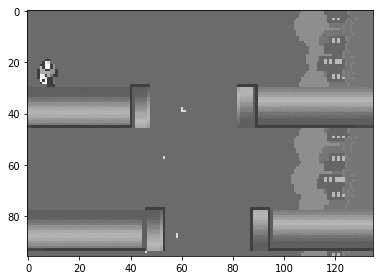

-------------


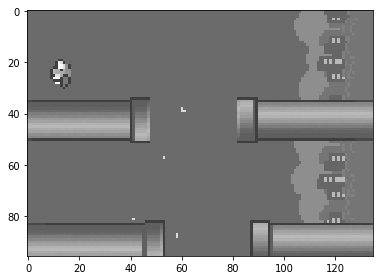

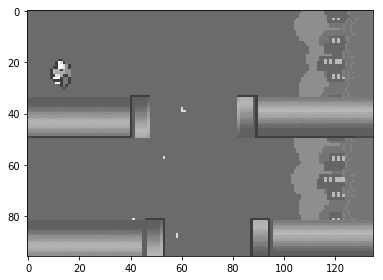

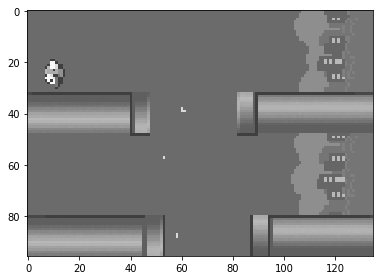

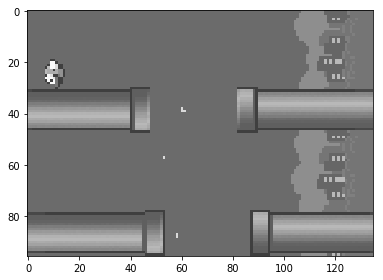

-------------


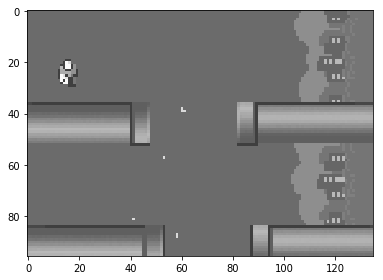

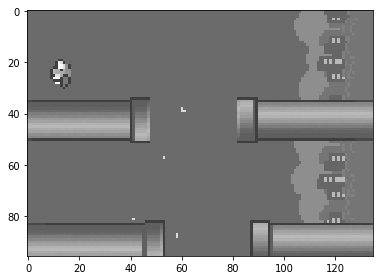

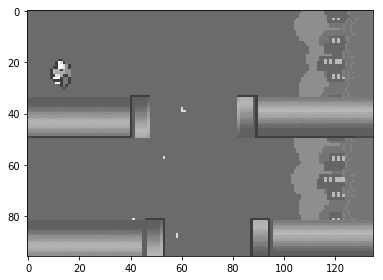

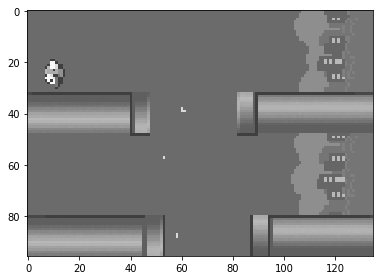

-------------


In [20]:
im = tsi[(len(tsi)-1)]
for i in range(1, 8):
    tsi[(len(tsi)-i)].plot()
    print '-------------'

In [ ]:
##BUFFER

In [166]:
replay_data[0][4]

False

In [110]:
import os
##disable graphics for cloud computing
#os.putenv('SDL_VIDEODRIVER', 'fbcon')
#os.environ["SDL_VIDEODRIVER"] = "dummy"

#%%time
output_file = 'logs/log'
#clear log file
open(output_file, 'w').close()

#init the game flappybird
game = FlappyBird()

#set up the screen
p = PLE(game, fps=30, display_screen=True)

p.init()

agent = PolicyAgent()

#tot_reward, tsi = test_game(agent, debug=True)
#print 'initial agent', tsi


observations = deque()

pre_training_weights = agent._model.get_weights()

'''values to change in AWS env'''
max_frames = 201#640000 ##first frame is null
num_frame_stacks = 4
num_to_observe = 20#3200 #observations before we train the network
batch_count = num_to_observe#int(num_to_observe * 0.8)  #train the model by selecting some subsample of the stored replays
                #contains lists of replay envs. each element is in the format
                #[state, action, reward, new_state, terminal(boolean)]
save_every = 50 ##save the weights of the model every x frames
frames_per_action = 5 #only act on every 5 frames
        
        
epsilon = 0.2 #choose best action 80% of the time
gamma = 0.8 #importance of future rewards compared to current reward
train_after_batch = True
count_game_over = 0
train_iteration_scores = []

replay_data = deque() 

game_over = False

#start time
start_time = timeit.default_timer()
for i in range(0, max_frames):
    #print '******* agent test', agent.predict(test_si.get_stacked_images())
    if i % (max_frames/10) == 0:
        elapsed = timeit.default_timer() - start_time
        with open(output_file, 'a') as log_handle:
            log_handle.write('done with ' + str(i) + ' frames with ' + str(elapsed) + ' seconds\n')
        
        #reset timer
        start_time = timeit.default_timer()
        
    if i % save_every == 0 and i != 0:
        f_name = 'model_weights_'+str(i)
        agent.save_weights(f_name)
    
    observation = p.getScreenRGB()
    if np.max(observation) != 0:
        observations.append(observation)
    
    
    ##after num_frame_stacks frames pass, we start predicting actions
    if len(observations) == num_frame_stacks:
        image_processors = [ImageProcessor(observations[j])
                           for j in range(num_frame_stacks)]
        stacked_images = StackedImages(image_processors, num_frame_stacks)
        
#         action = None
        if random.random() < epsilon:
            action, output = agent.predict(stacked_images.get_stacked_images())
        else:
            action = np.random.choice([119, None])

        ##update rewards    
        reward = update_reward(p.act(action))
        
                
        #get new state and create the replay data
        observation = p.getScreenRGB()
        replay_data.append([stacked_images, action, reward, 
                            ImageProcessor(observation),p.game_over()]) #(s, a, r, s', is_terminal)
        
        #remove the oldest state
        observations.popleft()
        
    else: ##first few frames, do nothing
        p.act(np.random.choice([119, None]))
    
    #if game over, reset the game and the observations queue
    if p.game_over():
        #train on game over
        if action == 119:
            target = [-5, 0]
        elif action == None:
            target = [0, -5]
        agent.fit(stacked_images.get_stacked_images(), target)
        
        stacked_images.plot()
        print target
        
        count_game_over += 1
        p.reset_game()
        observations = deque()
        print 'game reset', i
        
    #once we have enough data, train on a subsample of it
    if len(replay_data) == num_to_observe:
        pre_training_time = timeit.default_timer()
         
        agent = train_policy(agent, replay_data, num_frame_stacks=num_frame_stacks, batch_count=batch_count)
        
        training_time = timeit.default_timer() - pre_training_time
        with open(output_file, 'a') as log_handle:  
            log_handle.write('-----------TRAINING POLICY--------------\n')
            log_handle.write('training policy done with ' + str(training_time) + '\n')
            log_handle.write('--------------------------------------\n')

        
        if train_after_batch:
            pre_testing_time = timeit.default_timer()
            test_score = test_game(agent)
            train_iteration_scores.append([count_game_over, test_score]) 
            testing_time = timeit.default_timer() - pre_testing_time
            with open(output_file, 'a') as log_handle:  
                log_handle.write('-----------TEST PLAY--------------\n')
                log_handle.write('testing done with' + str(testing_time) + '\n')
                log_handle.write('--------------------------------------\n')
            
        
        ##reset
        #replay_data = deque()
        
        
        
        
        
        
with open(str(train_after_batch)+'_train_iteration_scores.pkl', 'wb') as f:
    pickle.dump(train_iteration_scores,f)
post_training_weights = agent._model.get_weights()
print('finished')

ValueError: Game requires 30fps, was given 30.

In [101]:
for i in range(len(pre_training_weights)):
    print np.max(pre_training_weights[i]),
print '\n'
for i in range(len(post_training_weights)):
    print np.max(post_training_weights[i]),

0.0371278 0.0 0.034199 0.0 0.700124 0.0 

0.0373119 0.000460094 0.035814 0.002946 0.69639 -0.00362027


In [102]:

tot_reward, tsi = test_game(agent, debug=True)
#print len(tsi)

(4, None, array([[ 0.24258856,  0.66232216]], dtype=float32))
(5, None, array([[ 0.24255855,  0.66235822]], dtype=float32))
(6, None, array([[ 0.24258296,  0.66219467]], dtype=float32))
(7, None, array([[ 0.24256641,  0.66225004]], dtype=float32))
(8, None, array([[ 0.24256742,  0.66228938]], dtype=float32))
(9, None, array([[ 0.2424868 ,  0.66246903]], dtype=float32))
(10, None, array([[ 0.24246421,  0.66246015]], dtype=float32))
(11, None, array([[ 0.24243724,  0.66249609]], dtype=float32))
(12, None, array([[ 0.24236645,  0.662606  ]], dtype=float32))
(13, None, array([[ 0.24237588,  0.66245657]], dtype=float32))
(14, None, array([[ 0.2422931 ,  0.66266441]], dtype=float32))
(15, None, array([[ 0.24211963,  0.66286331]], dtype=float32))
(16, None, array([[ 0.24213555,  0.66278476]], dtype=float32))
(17, None, array([[ 0.24206744,  0.66283685]], dtype=float32))
(18, None, array([[ 0.24195157,  0.66291231]], dtype=float32))
(19, None, array([[ 0.24197128,  0.66290665]], dtype=float32)

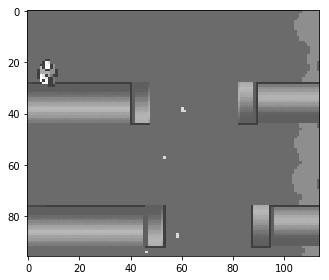

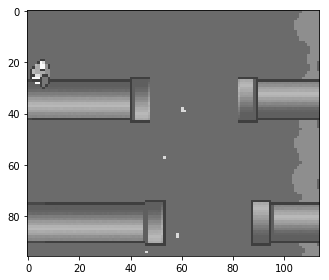

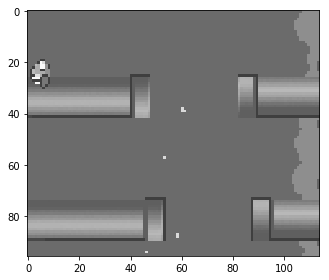

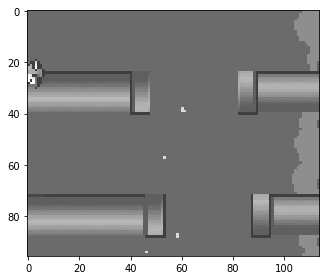

In [103]:
test_si.plot()

In [104]:
agent.predict(test_si.get_stacked_images())

(None, array([[ 0.24107401,  0.66405457]], dtype=float32))

In [12]:
test_si = tsi[len(tsi)-1]
for i in range(10):
    print agent.predict(tsi[len(tsi)-i-1].get_stacked_images())
#agent.predict(tsi[len(tsi)-5].get_stacked_images())

(119, array([[ 0.41975379,  0.05221501]], dtype=float32))
(119, array([[ 0.41975057,  0.05221502]], dtype=float32))
(119, array([[ 0.41974631,  0.05221509]], dtype=float32))
(119, array([[ 0.41974789,  0.05221551]], dtype=float32))
(119, array([[ 0.41974682,  0.05221516]], dtype=float32))
(119, array([[ 0.41974461,  0.05221503]], dtype=float32))
(119, array([[ 0.4197489 ,  0.05221577]], dtype=float32))
(119, array([[ 0.41975075,  0.05221606]], dtype=float32))
(119, array([[ 0.41974688,  0.05221606]], dtype=float32))
(119, array([[ 0.419756  ,  0.05221669]], dtype=float32))


In [107]:
test_game(agent, show_screen=True)

-2.199999999999999

In [ ]:
model_name = str(train_after_batch)+'_model'
agent._model.save('models/'+model_name)

In [ ]:
model = load_model('models/'+model_name)


In [ ]:
model.summary()

In [ ]:
train_iteration_scores

In [39]:
agent.save_weights('weights')

In [40]:
agent._model.load_weights('weights')

In [34]:
a, agent

(<__main__.PolicyAgent instance at 0x1c3d3b5248>,
 <__main__.PolicyAgent instance at 0x1c3859f830>)

In [50]:
for i in range(100):
    print update_reward(p.act(None)),

0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
